# Overview

**GENERAL THOUGHTS:**
- How to handle SKUs with mulitple components? Does it make more sense to combine them into a single row? -> might want to try this as a next step


**DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

categorical data:
- Ordinal Data: The categories have an inherent order
- Nominal Data: The categories do not have an inherent order

Options:
- nominal encode 'material_number'
- nominal encode 'material_number_text'
- nominal encode 'brand'
- nominal encode 'product_area'
- ...


**MULTI-CLASS CLASSIFIER:**
- Focus on "Native Multiclass Classifiers" as a starting point. Might try "Binary Transformation" or "Hierarchical Classification" later. https://www.projectpro.io/article/multi-class-classification-python-example/547
- Overview models to be considered:  
X: to be considered
  - [] Naive Bayes 
  - [] Decision Trees
  - [] K-Nearest Neighbors
  - [X] Ensemble Models (~~Random Forest~~, XGBoost)
  - [] Neural Networks


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgbm

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


# Load data

In [3]:
df = pd.read_csv('../../data/output/df_ml.csv', sep='\t')

In [4]:
df.head()

,material_number,material_number_text,brand,product_area,core_segment,component,component_text,manufactoring_location,characteristic_value,material_weight,packaging_code,packaging_category
0,45733343,Counter Display,BOT,PA5,Metal Grinding,6035765C21,Corrugated carton,Distribution Center,CORRUGATED,85.00,PCode_664273,D1 - Countertop display
1,45733343,Counter Display,BOT,PA5,Metal Grinding,6035940565,Label SB,Distribution Center,WOOD FREE,0.54,PCode_560426,D1 - Countertop display
2,45733343,Counter Display,BOT,PA5,Metal Grinding,6035822768,Tight -Pack label RB - 1ER,Distribution Center,MCB/GT2,22.90,PCode_481002,D1 - Countertop display
3,45733343,Counter Display,BOT,PA5,Metal Grinding,6035822768,Tight -Pack label RB - 1ER,Distribution Center,MCB/GT2,22.90,PCode_481002,D1 - Countertop display
4,45733343,Counter Display,BOT,PA5,Metal Grinding,6035765P54,Corrugated carton,Distribution Center,CORRUGATED,85.00,PCode_664273,D1 - Countertop display


# Prep data for machine learning

## Clean data

In [5]:
df['material_number'] = df['material_number'].astype('object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82977 entries, 0 to 82976
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   material_number         82977 non-null  object 
 1   material_number_text    82977 non-null  object 
 2   brand                   82977 non-null  object 
 3   product_area            82977 non-null  object 
 4   core_segment            82977 non-null  object 
 5   component               82977 non-null  object 
 6   component_text          82977 non-null  object 
 7   manufactoring_location  82977 non-null  object 
 8   characteristic_value    82977 non-null  object 
 9   material_weight         75913 non-null  float64
 10  packaging_code          82977 non-null  object 
 11  packaging_category      82977 non-null  object 
dtypes: float64(1), object(11)
memory usage: 7.6+ MB


In [7]:
df.describe()

,material_weight
count,7.591300e+04
mean,4.926976e+02
std,3.123181e+04
min,0.000000e+00
25%,8.000000e-01
50%,5.000000e+00
75%,2.500000e+01
max,2.300000e+06


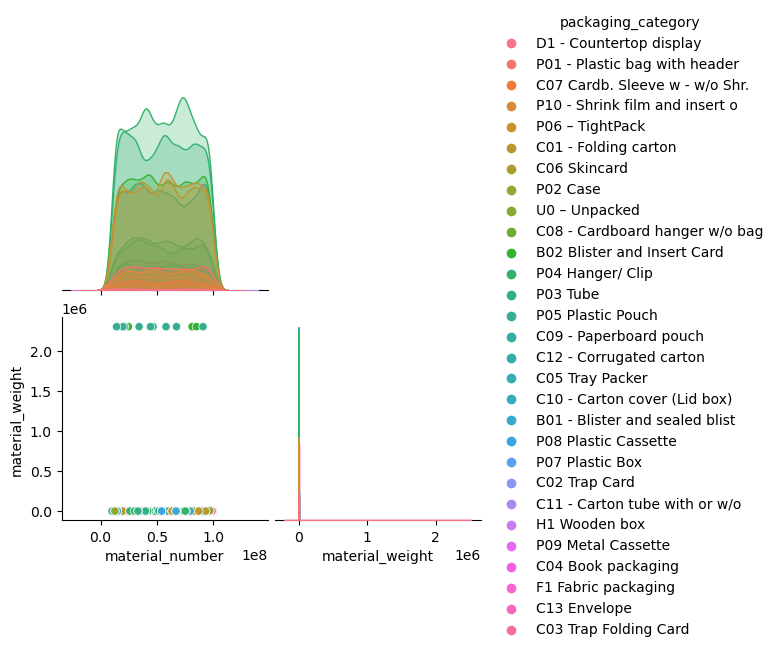

In [8]:
num_features = df.select_dtypes(include=np.number).columns

sns.pairplot(
    data=df,
    # kind='scatter',
    corner=True,
    hue='packaging_category',
    # vars=num_features
)

(82977,)
(75794, 12)


array([[<Axes: title={'center': 'material_weight'}>]], dtype=object)

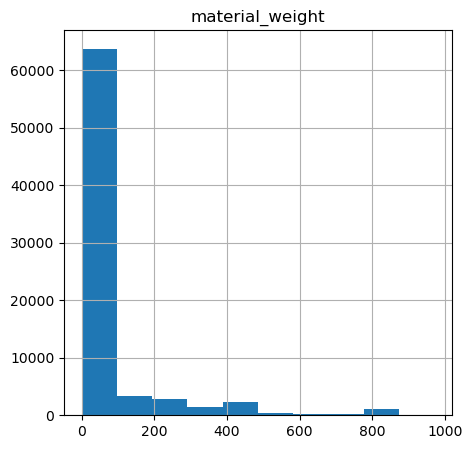

In [9]:
print(df.material_weight.shape)
print(df[df.material_weight <= 1000].shape)
df[df.material_weight <= 1000].hist(figsize=(5, 5))

<Figure size 1000x500 with 0 Axes>

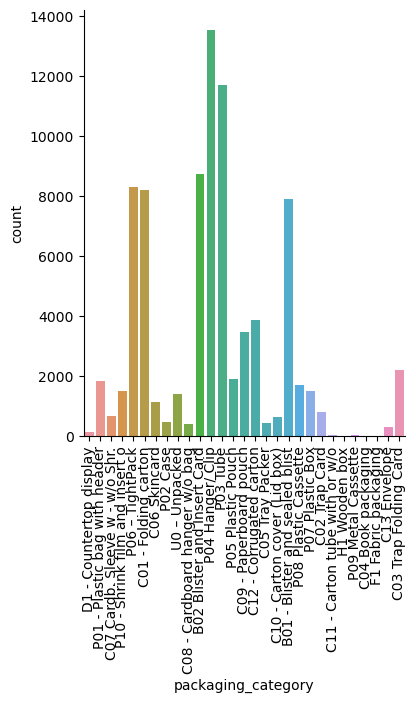

In [10]:
plt.figure(figsize=(10,5))
cat_chart = sns.catplot(
    data=df,
    x='packaging_category',
    kind='count',
)
cat_chart.set_xticklabels(rotation=90)

<Figure size 1000x500 with 0 Axes>

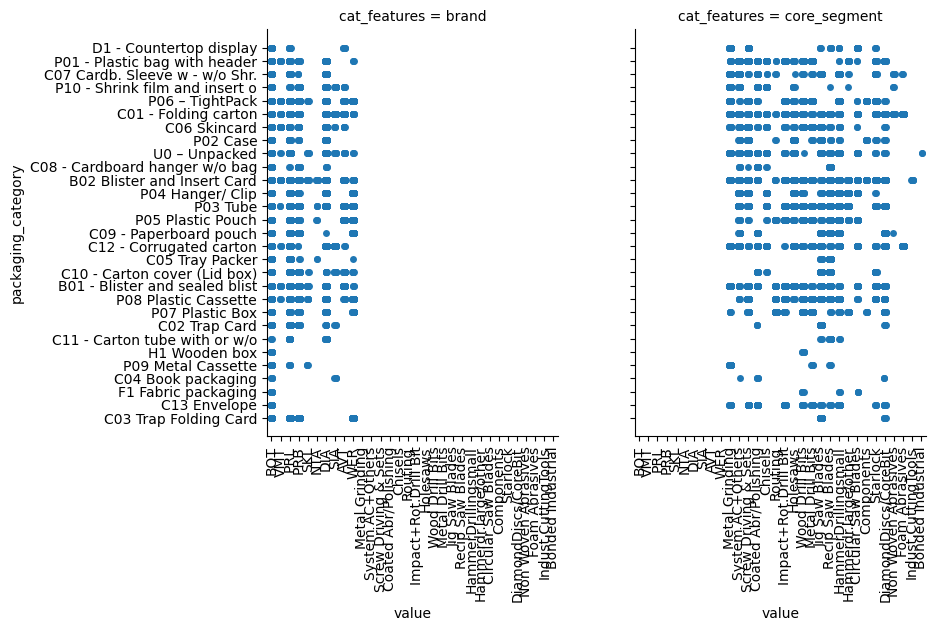

In [11]:
# transform from wide to long, then plot using the column 'features' to facet
# df_cat = df.select_dtypes(include=['object']).melt(id_vars=['packaging_category'], var_name='cat_features')
df_cat = df[['brand', 'core_segment', 'packaging_category']].select_dtypes(include=['object']).melt(id_vars=['packaging_category'], var_name='cat_features')

plt.figure(figsize=(10,5))
cat_chart = sns.catplot(
    data=df_cat,
    x='value',
    y='packaging_category',
    col='cat_features',
)
cat_chart.set_xticklabels(rotation=90)

In [12]:
df_sub = df[[
    'material_number',
    'brand',
    'product_area',
    'core_segment',
    'component',
    'manufactoring_location',
    'characteristic_value',
    'material_weight', 
    'packaging_code',
    'packaging_category',
]]

In [13]:
df_sub = df_sub.dropna()

## Split data into train/test

In [14]:
# Define features and target
X = df_sub.iloc[:, :-1]
y = df_sub.iloc[:, -1]  # the last column is the target

In [15]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

In [16]:
print("Unique categories in y_train: ", y_train.nunique())
print("Unique categories in y_test: ", y_test.nunique())

Unique categories in y_train:  29
Unique categories in y_test:  29


## Data preprocessing

# Build baseline model

In [17]:
class CustomClassifierMode(BaseEstimator, ClassifierMixin):
    """Classifier that predicts the most frequent value. Does not support usage within sklearn pipelines when "LabelEncoder" is used.
    """

    def __init__(self):
        self.mode_pred = np.nan
        return

    def fit(self, X, y: pd.Series):
        """
        Args:
            y (pandas series): any pandas series - e.g. y_train, the target variable
        Returns:
            the most frequent value of y
        """
        self.mode_pred = y.mode()[0]
        return 
    
    def predict(self, X: pd.DataFrame, y=None):
        """
        Args:
            X (pandas DataFrame): any pandas DataFrame - e.g. X_train, the feature set
        Returns:
            the predictions as constant mode value
        """
        return np.full((X.shape[0]), self.mode_pred)

In [18]:
# execute outside pipeline
baseline_mode = CustomClassifierMode()
baseline_mode.fit(X=X_train, y=y_train)
print("Train score (f1-score): ", baseline_mode.score(X_train, y_train))
print("Test score (f1-score): ", baseline_mode.score(X_test, y_test))

y_pred_baseline_mode = baseline_mode.predict(X=X_test)
print(classification_report(y_test, y_pred_baseline_mode))

Train score (f1-score):  0.16709008449538004
Test score (f1-score):  0.16707649073504874


/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.00      0.00      0.00      2155
   B02 Blister and Insert Card       0.00      0.00      0.00      2475
          C01 - Folding carton       0.00      0.00      0.00      2172
                 C02 Trap Card       0.00      0.00      0.00       231
         C03 Trap Folding Card       0.00      0.00      0.00       644
            C04 Book packaging       0.00      0.00      0.00         3
               C05 Tray Packer       0.00      0.00      0.00       127
                  C06 Skincard       0.00      0.00      0.00       332
C07 Cardb. Sleeve w - w/o Shr.       0.00      0.00      0.00       160
C08 - Cardboard hanger w/o bag       0.00      0.00      0.00       115
        C09 - Paperboard pouch       0.00      0.00      0.00       832
  C10 - Carton cover (Lid box)       0.00      0.00      0.00       142
 C11 - Carton tube with or w/o       0.00      0.00      0.00  

/Users/dat/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# execute outside pipeline
baseline_strati = DummyClassifier(strategy="stratified", random_state=42)
baseline_strati.fit(X=X_train, y=y_train)
y_pred_train_baseline_strati = baseline_strati.predict(X=X_train)
print("Train score (f1-score): ", baseline_strati.score(X_train, y_train))
print("Test score (f1-score): ", baseline_strati.score(X_test, y_test))

y_pred_baseline_strati = baseline_strati.predict(X=X_test)
print(classification_report(y_test, y_pred_baseline_strati))

Train score (f1-score):  0.09524078360526167
Test score (f1-score):  0.09563537367173092
                                precision    recall  f1-score   support

B01 - Blister and sealed blist       0.09      0.09      0.09      2155
   B02 Blister and Insert Card       0.10      0.10      0.10      2475
          C01 - Folding carton       0.09      0.09      0.09      2172
                 C02 Trap Card       0.00      0.00      0.00       231
         C03 Trap Folding Card       0.04      0.04      0.04       644
            C04 Book packaging       0.00      0.00      0.00         3
               C05 Tray Packer       0.01      0.01      0.01       127
                  C06 Skincard       0.01      0.01      0.01       332
C07 Cardb. Sleeve w - w/o Shr.       0.02      0.02      0.02       160
C08 - Cardboard hanger w/o bag       0.00      0.00      0.00       115
        C09 - Paperboard pouch       0.04      0.04      0.04       832
  C10 - Carton cover (Lid box)       0.02     

# Baseline pipeline

## pre-processing pipeline

In [20]:
# DEFINE & EXECUTE PIPELINE

# define feature processing pipeline
# define numerical feature processing
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on seperate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])

## baseline_mode pipeline

In [21]:
# Combine pipelines (pre-processing & classifier (mode))
baseline_mode_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline), 
        ("baseline_mode", DummyClassifier(strategy="most_frequent", random_state=42))
    ]
)

# encode target variable
# TODO: default order is alphabetic, might want to change order according to connection of packaging groups
label_ecoder = LabelEncoder()
y_train_encoded = pd.DataFrame(label_ecoder.fit_transform(y_train))
y_test_encoded = pd.DataFrame(label_ecoder.fit_transform(y_test))

# fit the pipeline
baseline_mode_pipeline.fit(X_train, y_train_encoded)

# score the pipeline
print("Train score (f1-score): ", baseline_mode_pipeline.score(X_train, y_train_encoded))
print("Test score (f1-score): ", baseline_mode_pipeline.score(X_test, y_test_encoded))

Train score (f1-score):  0.16709008449538004
Test score (f1-score):  0.16707649073504874


In [22]:
# Generate predictions
y_pred = baseline_mode_pipeline.predict(X_test)
preds_y_test_inverse = label_ecoder.inverse_transform(y_pred)
preds_y_test_inverse

array(['P04 Hanger/ Clip', 'P04 Hanger/ Clip', 'P04 Hanger/ Clip', ...,
       'P04 Hanger/ Clip', 'P04 Hanger/ Clip', 'P04 Hanger/ Clip'],
      dtype=object)

In [23]:
# display example predictions and actual values
y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test
0,B02 Blister and Insert Card,P04 Hanger/ Clip
1,P04 Hanger/ Clip,P04 Hanger/ Clip
2,B02 Blister and Insert Card,P04 Hanger/ Clip
3,P04 Hanger/ Clip,P04 Hanger/ Clip
4,P01 - Plastic bag with header,P04 Hanger/ Clip
5,C06 Skincard,P04 Hanger/ Clip
6,C07 Cardb. Sleeve w - w/o Shr.,P04 Hanger/ Clip
7,P03 Tube,P04 Hanger/ Clip
8,P06 – TightPack,P04 Hanger/ Clip
9,P06 – TightPack,P04 Hanger/ Clip
